Задание 1.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, Lasso, RidgeCV, Ridge, ElasticNet
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder']
(760, 62, 47)


^ Какая-то у меня проблема с датасетом, я не могу понять, почему в нем мало лиц и имен, с чем это связано и как пофиксить (pip install scikit-learn --upgrade не сработало) 

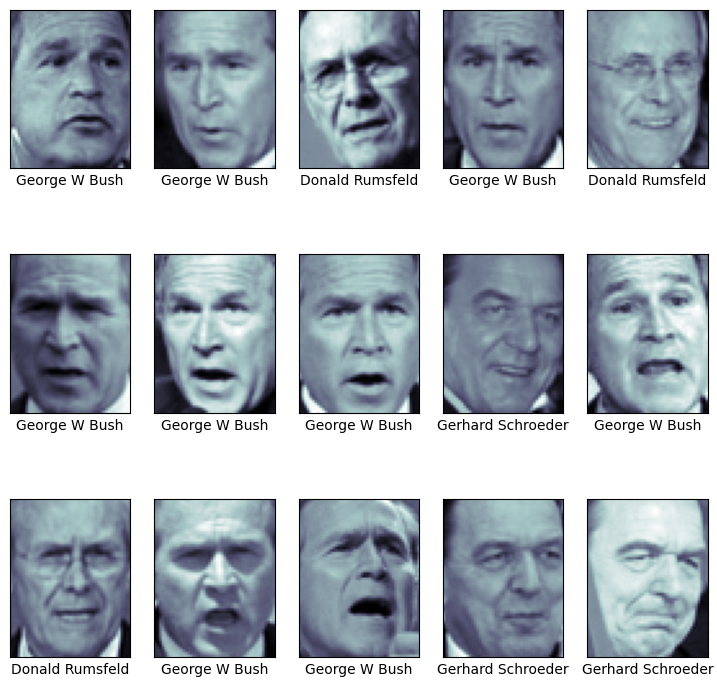

In [3]:
fig, ax = plt.subplots(3, 5, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [4]:
pca = PCA(n_components=150, svd_solver='randomized', whiten=True, random_state=42)

In [5]:
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

In [6]:
def plotting(grid, params):
    """Функция для построения графиков"""
    scores_mean = grid.cv_results_['mean_test_score']
    scores_sd = grid.cv_results_['std_test_score']

    fig, ax = plt.subplots()
    ax.plot(params,scores_mean)
    ax.fill_between(params, (scores_mean-scores_sd), (scores_mean+scores_sd), color='g', alpha=.1)

In [7]:
def model_train(model, param_grid, hyperparams):
    """Функция подбора гиперпараметров, вызывает функцию с графиками"""
    grid = GridSearchCV(model, param_grid, scoring='roc_auc')  # если не передавать cv явно, как раз будет использована 5-fold cv
    grid.fit(Xtrain, ytrain)
    plotting(grid, hyperparams)
    print(f'Best params: {grid.best_params_}')
    best = grid.best_estimator_
    y_pred_train = best.predict(Xtrain)
    y_pred_test = best.predict(Xtest)
    print(classification_report(ytrain, y_pred_train), classification_report(ytest, y_pred_test))
    print(roc_auc_score(ytrain, y_pred_train), roc_auc_score(ytest, y_pred_test))

In [8]:
model = LogisticRegression(solver="liblinear")
model.fit(Xtrain, ytrain)
preds = model.predict_proba(Xtest)

roc_auc = roc_auc_score(ytest, preds, multi_class='ovr')
print(roc_auc)
roc_auc = roc_auc_score(ytest, preds, multi_class='ovo')
print(roc_auc)

0.9825550470221268
0.981315140212334


In [9]:
model = LogisticRegression(solver="newton-cg")
model.fit(Xtrain, ytrain)
preds = model.predict_proba(Xtest)

roc_auc = roc_auc_score(ytest, preds, multi_class='ovr')
print(roc_auc)
roc_auc = roc_auc_score(ytest, preds, multi_class='ovo')
print(roc_auc)

0.98089400212327
0.9797209352021836


In [10]:
model = LogisticRegression(solver="newton-cholesky")
model.fit(Xtrain, ytrain)
preds = model.predict_proba(Xtest)

roc_auc = roc_auc_score(ytest, preds, multi_class='ovr')
print(roc_auc)
roc_auc = roc_auc_score(ytest, preds, multi_class='ovo')
print(roc_auc)

0.9820296903246741
0.9810018843916039


In [11]:
model = KNeighborsClassifier()
model.fit(Xtrain, ytrain)
preds = model.predict_proba(Xtest)

roc_auc = roc_auc_score(ytest, preds, multi_class='ovr')
print(roc_auc)
roc_auc = roc_auc_score(ytest, preds, multi_class='ovo')
print(roc_auc)

0.7691943914150355
0.7539357315616168


In [12]:
model = SGDClassifier(loss='log_loss')
model.fit(Xtrain, ytrain)
preds = model.predict_proba(Xtest)

roc_auc = roc_auc_score(ytest, preds, multi_class='ovr')
print(roc_auc)
roc_auc = roc_auc_score(ytest, preds, multi_class='ovo')
print(roc_auc)

0.9385540183395022
0.9362044807724063


In [13]:
model = SGDClassifier(loss='modified_huber')
model.fit(Xtrain, ytrain)
preds = model.predict_proba(Xtest)

roc_auc = roc_auc_score(ytest, preds, multi_class='ovr')
print(roc_auc)
roc_auc = roc_auc_score(ytest, preds, multi_class='ovo')
print(roc_auc)

0.9357531267606881
0.9361255597322998


In [14]:
svc = SVC()
model = make_pipeline(pca, svc)

param_grid = {'svc__kernel': ['poly', 'rbf', 'sigmoid']}
grid = GridSearchCV(model, param_grid)

grid.fit(Xtrain, ytrain)

print(grid.best_params_)

{'svc__kernel': 'sigmoid'}


Ядро poly

In [15]:
svc = SVC(kernel='poly')
model = make_pipeline(pca, svc)

In [16]:
param_grid = {'svc__C': [1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)

print(grid.best_params_)

CPU times: total: 4.53 s
Wall time: 5.01 s
{'svc__C': 5}


In [17]:
model = grid.best_estimator_

yfit = model.predict(Xtest)

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

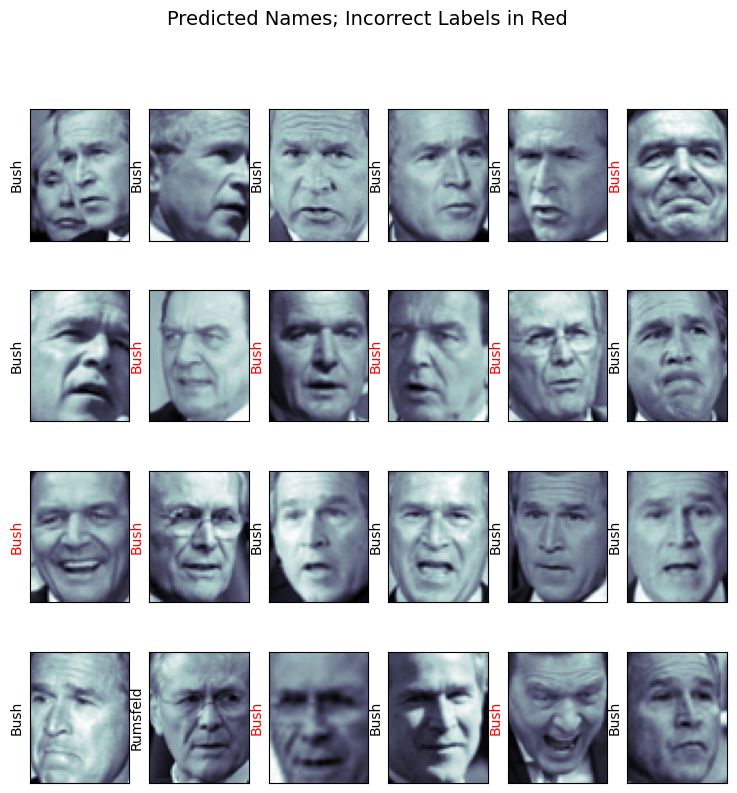

In [18]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)

In [19]:
print(classification_report(ytest, yfit,
                            target_names=faces.target_names,
                            zero_division=0))

                   precision    recall  f1-score   support

  Donald Rumsfeld       1.00      0.08      0.15        36
    George W Bush       0.66      1.00      0.79       123
Gerhard Schroeder       0.00      0.00      0.00        31

         accuracy                           0.66       190
        macro avg       0.55      0.36      0.32       190
     weighted avg       0.62      0.66      0.54       190



In [20]:
accuracy_score(yfit, ytest)

0.6631578947368421

Text(72.7222222222222, 0.5, 'predicted label')

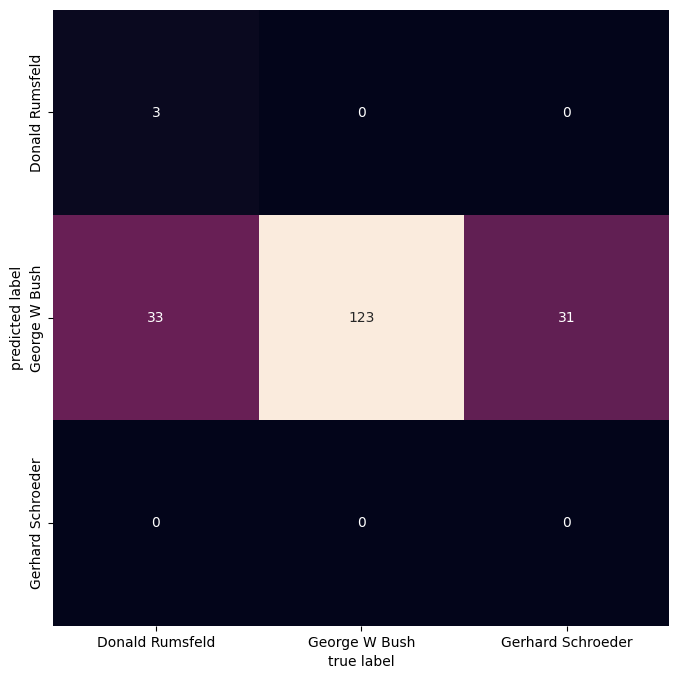

In [21]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

Ядро rbf

In [22]:
svc = SVC(kernel='rbf')
model = make_pipeline(pca, svc)

In [23]:
param_grid = {'svc__C': [1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)

print(grid.best_params_)

CPU times: total: 5.22 s
Wall time: 5.22 s
{'svc__C': 5}


In [24]:
model = grid.best_estimator_

yfit = model.predict(Xtest)

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

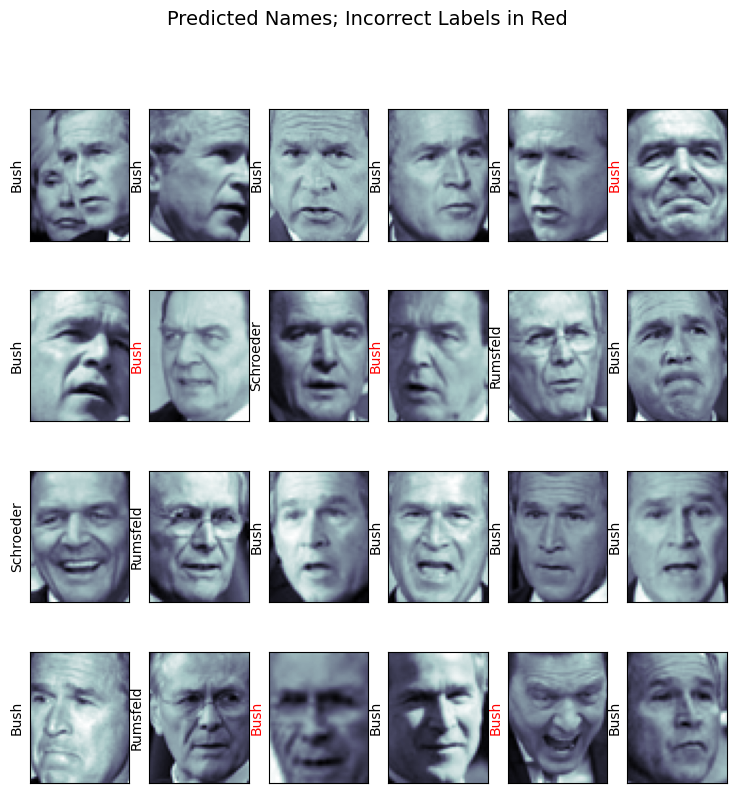

In [25]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)

In [26]:
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

  Donald Rumsfeld       1.00      0.64      0.78        36
    George W Bush       0.83      1.00      0.90       123
Gerhard Schroeder       1.00      0.58      0.73        31

         accuracy                           0.86       190
        macro avg       0.94      0.74      0.81       190
     weighted avg       0.89      0.86      0.85       190



In [27]:
accuracy_score(yfit,ytest)

0.8631578947368421

Text(72.7222222222222, 0.5, 'predicted label')

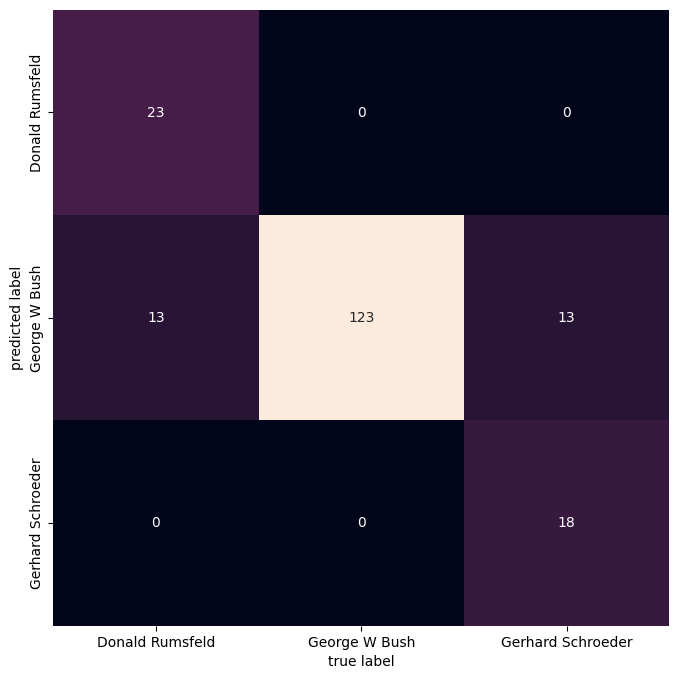

In [28]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

Ядро sigmoid (лучший результат)

In [29]:
svc = SVC(kernel='sigmoid')
model = make_pipeline(pca, svc)

In [30]:
param_grid = {'svc__C': [1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)

print(grid.best_params_)

CPU times: total: 2 s
Wall time: 4.48 s
{'svc__C': 1}


In [31]:
model = grid.best_estimator_

yfit = model.predict(Xtest)

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

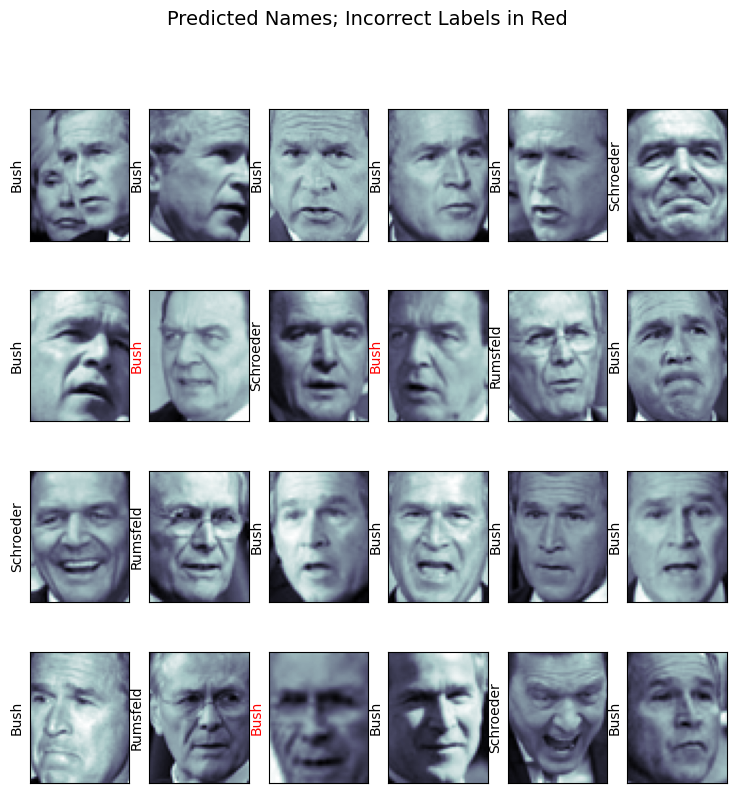

In [32]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)

In [33]:
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

  Donald Rumsfeld       0.92      0.67      0.77        36
    George W Bush       0.85      0.98      0.91       123
Gerhard Schroeder       0.91      0.68      0.78        31

         accuracy                           0.87       190
        macro avg       0.90      0.77      0.82       190
     weighted avg       0.87      0.87      0.86       190



In [34]:
accuracy_score(yfit,ytest)

0.868421052631579

Text(72.7222222222222, 0.5, 'predicted label')

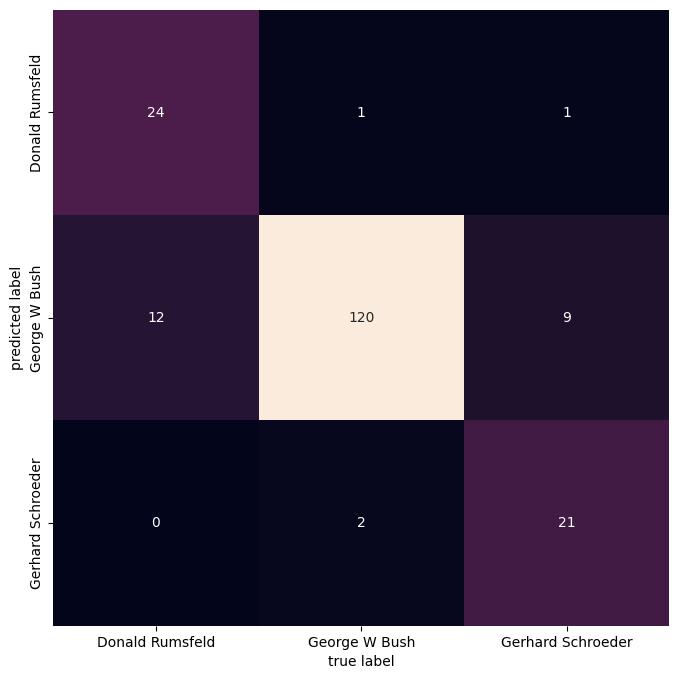

In [35]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

Задание 2

In [36]:
lr = LogisticRegression()
model = make_pipeline(pca, lr)

In [37]:
param_grid = {'logisticregression__C': [0.01, 1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)

grid.fit(Xtrain, ytrain)

print(grid.best_params_)

{'logisticregression__C': 1}


In [38]:
model = grid.best_estimator_

yfit = model.predict(Xtest)

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

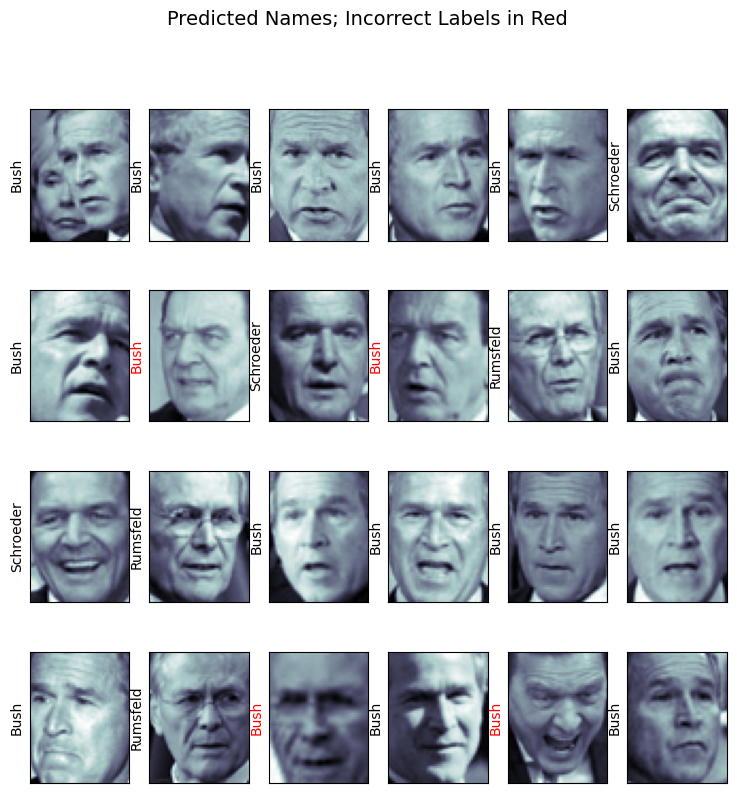

In [39]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)

In [40]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

  Donald Rumsfeld       0.91      0.81      0.85        36
    George W Bush       0.89      0.96      0.93       123
Gerhard Schroeder       0.92      0.77      0.84        31

         accuracy                           0.90       190
        macro avg       0.91      0.85      0.87       190
     weighted avg       0.90      0.90      0.90       190



Text(72.7222222222222, 0.5, 'predicted label')

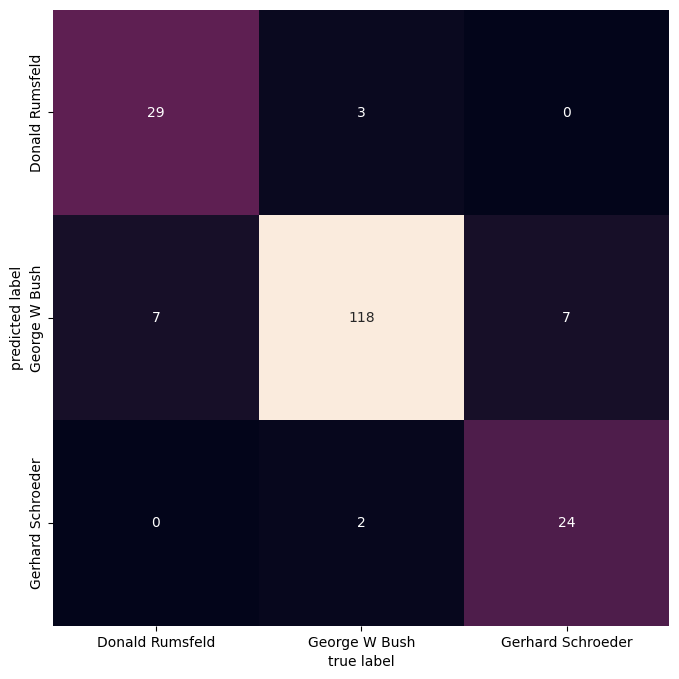

In [41]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8,8))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(yfit,ytest)

0.9

Попыталась объединить три модели, но ничего не работает

In [43]:
np.seterr (invalid='ignore')
model1 = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC(kernel='sigmoid', probability=True))
])
model2 = Pipeline([
    ('scale', StandardScaler()),
    ('sgd', SGDClassifier(loss='log_loss'))
])
model3 = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegression(solver="liblinear", C=0.01))
])
model1.fit(Xtrain, ytrain)
model2.fit(Xtrain, ytrain)
model3.fit(Xtrain, ytrain)

clf1 = model1.predict_proba(Xtest)
clf2 = model2.predict_proba(Xtest)
clf3 = model3.predict_proba(Xtest)

In [44]:
scores = []
for alpha in np.arange(0.1, 1.1, 0.1):
    res = alpha * clf1 + (1 - alpha) * clf2 + (1 - alpha) * clf3
    res
    pred = []
    for elem in res:
        pred.append(np.argmax(elem))
    scores.append(roc_auc_score(ytest, preds, multi_class='ovr')) 
    
    print('alpha:', round(alpha, 1), 'score:', scores[-1])
    

alpha: 0.1 score: 0.9357531267606881
alpha: 0.2 score: 0.9357531267606881
alpha: 0.3 score: 0.9357531267606881
alpha: 0.4 score: 0.9357531267606881
alpha: 0.5 score: 0.9357531267606881
alpha: 0.6 score: 0.9357531267606881
alpha: 0.7 score: 0.9357531267606881
alpha: 0.8 score: 0.9357531267606881
alpha: 0.9 score: 0.9357531267606881
alpha: 1.0 score: 0.9357531267606881


Задание 3

In [45]:
data = pd.read_csv(r"C:\Users\mkuzo\Desktop\Программирование_2 сем\mag2022\CL\term02\04-ClassificationTrees\winequalityN.csv")
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [47]:
data = data.dropna()

In [48]:
data['type'].value_counts()

white    4870
red      1593
Name: type, dtype: int64

In [49]:
data['type'] = data['type'].apply(lambda x : 0 if x == 'red' else 1)

In [50]:
X = data.drop('quality', axis=1)
y = data['quality']

In [51]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42)

In [52]:
scaler = MinMaxScaler().fit(Xtrain)
X_train = scaler.transform(Xtrain)
X_test = scaler.transform(Xtest)

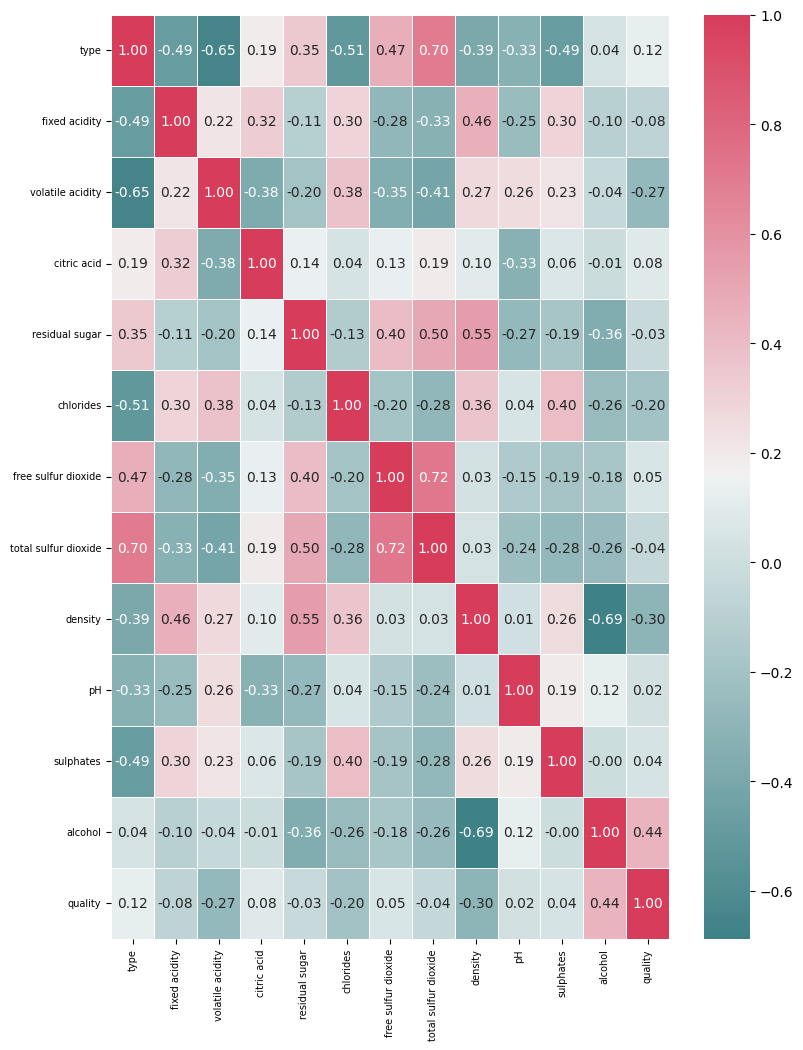

In [53]:
data_1 = pd.DataFrame(data=np.c_[data.drop(columns = 'quality', axis = 1), data['quality']],
                     columns=list(data.drop(columns = 'quality', axis = 1)) + ['quality'])

plt.figure(figsize=(9,12))

corr = data_1.corr()

g = sns.heatmap(corr,annot=True,linewidths=.5,fmt= '.2f',\
            mask=np.zeros_like(corr, dtype=bool), \
            cmap=sns.diverging_palette(200, 5,as_cmap=True))

g.set_xticklabels(g.get_xticklabels(), fontsize = 7)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 7)
plt.show()

In [54]:
def plotting(grid, params):
    """Функция для построения графиков"""
    scores_mean = grid.cv_results_['mean_test_score']
    scores_sd = grid.cv_results_['std_test_score']

    fig, ax = plt.subplots()
    ax.plot(params,scores_mean)
    ax.fill_between(params, (scores_mean-scores_sd), (scores_mean+scores_sd), color='g', alpha=.1)

In [55]:
def model_train(model, param_grid, hyperparams):
    """Функция подбора гиперпараметров, вызывает функцию с графиками"""
    grid = GridSearchCV(model, param_grid)  
    grid.fit(Xtrain, ytrain)
    plotting(grid, hyperparams)
    print(f'Best params: {grid.best_params_}')
    best = grid.best_estimator_
    y_pred_train = best.predict(Xtrain)
    y_pred_test = best.predict(Xtest)
    print(classification_report(ytrain, y_pred_train, zero_division=0), classification_report(ytest, y_pred_test, zero_division=0))


KNN results


C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best params: {'n_neighbors': 2}
              precision    recall  f1-score   support

           3       0.65      1.00      0.79        24
           4       0.68      0.98      0.80       156
           5       0.74      0.98      0.84      1588
           6       0.85      0.78      0.81      2134
           7       0.93      0.56      0.70       800
           8       1.00      0.36      0.53       141
           9       0.00      0.00      0.00         4

    accuracy                           0.80      4847
   macro avg       0.69      0.66      0.64      4847
weighted avg       0.82      0.80      0.79      4847
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.10      0.14      0.11        58
           5       0.48      0.66      0.56       540
           6       0.54      0.49      0.51       686
           7       0.54      0.27      0.36       274
           8       0.50      0.08      0.14   

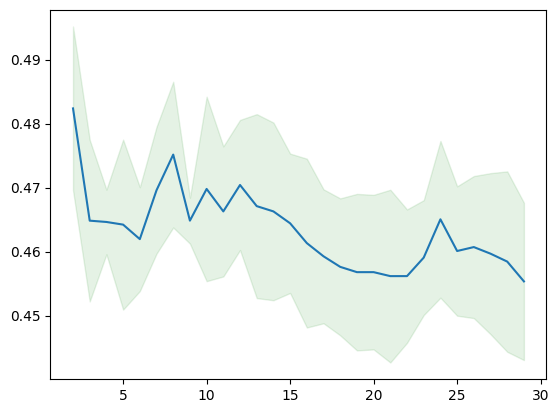

In [56]:
model = KNeighborsClassifier()
hyperparams = list(range(2, 30)) # k=2 до k=30
param_grid = {'n_neighbors': hyperparams}
print('KNN results')
model_train(model, param_grid, hyperparams)

In [57]:
grid = GridSearchCV(model, param_grid)

grid.fit(Xtrain, ytrain)

print(grid.best_params_)

C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'n_neighbors': 2}


Normalised KNN results


C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best params: {'knn__n_neighbors': 4}
              precision    recall  f1-score   support

           3       0.43      0.12      0.19        24
           4       0.65      0.43      0.52       156
           5       0.71      0.83      0.77      1588
           6       0.74      0.74      0.74      2134
           7       0.74      0.59      0.66       800
           8       0.75      0.38      0.50       141
           9       0.00      0.00      0.00         4

    accuracy                           0.72      4847
   macro avg       0.57      0.44      0.48      4847
weighted avg       0.72      0.72      0.72      4847
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.29      0.14      0.19        58
           5       0.61      0.71      0.65       540
           6       0.58      0.61      0.60       686
           7       0.50      0.40      0.45       274
           8       0.19      0.06      0.

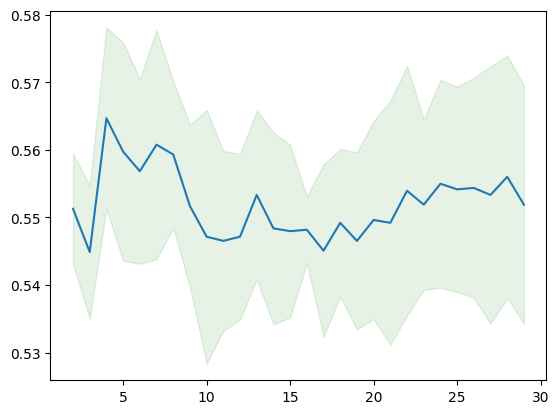

In [58]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
hyperparams = list(range(2, 30))
param_grid = {'knn__n_neighbors': hyperparams}
print('Normalised KNN results')
model_train(model, param_grid, hyperparams)

SGD results


C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best params: {'loss': 'modified_huber'}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00       156
           5       0.64      0.05      0.10      1588
           6       0.45      0.97      0.61      2134
           7       0.43      0.05      0.09       800
           8       0.00      0.00      0.00       141
           9       0.00      0.00      0.00         4

    accuracy                           0.45      4847
   macro avg       0.22      0.15      0.11      4847
weighted avg       0.48      0.45      0.32      4847
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        58
           5       0.53      0.06      0.10       540
           6       0.43      0.96      0.60       686
           7       0.45      0.05      0.10       274
           8       0.00      0.00     

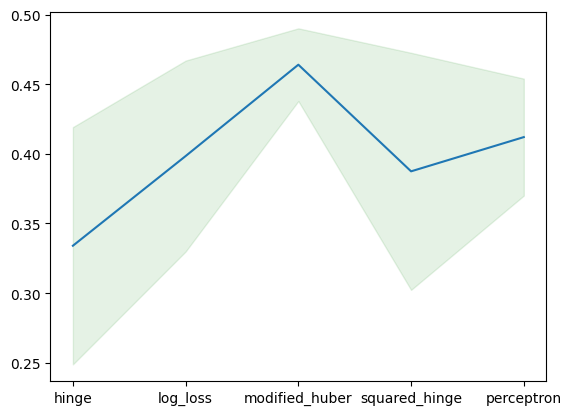

In [59]:
model = SGDClassifier()
hyperparams = ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']
param_grid = {'loss': hyperparams}
print('SGD results')
model_train(model, param_grid, hyperparams)

In [60]:
grid = GridSearchCV(model, param_grid)

grid.fit(Xtrain, ytrain)

print(grid.best_params_)

C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'loss': 'squared_hinge'}


Normalised SGD results


C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\mkuzo\AppData\Local\Packages\PythonSoft

Best params: {'sgd__loss': 'log_loss'}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00        24
           4       0.44      0.07      0.12       156
           5       0.55      0.49      0.52      1588
           6       0.49      0.75      0.59      2134
           7       0.52      0.08      0.14       800
           8       0.36      0.03      0.05       141
           9       0.00      0.00      0.00         4

    accuracy                           0.51      4847
   macro avg       0.34      0.20      0.20      4847
weighted avg       0.51      0.51      0.46      4847
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.47      0.16      0.23        58
           5       0.61      0.50      0.55       540
           6       0.48      0.78      0.60       686
           7       0.55      0.11      0.18       274
           8       0.00      0.00      

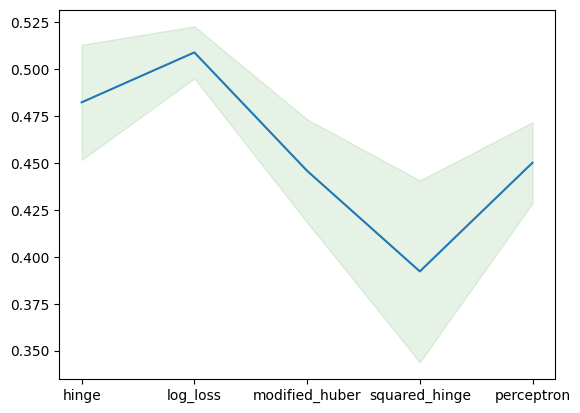

In [61]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('sgd', SGDClassifier())
])
hyperparams = ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']
param_grid = {'sgd__loss': hyperparams}
print('Normalised SGD results')
model_train(model, param_grid, hyperparams)

LogisticRegression results


C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\

Best params: {'solver': 'newton-cg'}
              precision    recall  f1-score   support

           3       1.00      0.04      0.08        24
           4       0.67      0.01      0.03       156
           5       0.59      0.59      0.59      1588
           6       0.52      0.74      0.61      2134
           7       0.51      0.17      0.26       800
           8       0.00      0.00      0.00       141
           9       0.00      0.00      0.00         4

    accuracy                           0.54      4847
   macro avg       0.47      0.22      0.22      4847
weighted avg       0.53      0.54      0.51      4847
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.38      0.05      0.09        58
           5       0.62      0.57      0.59       540
           6       0.51      0.73      0.60       686
           7       0.47      0.21      0.29       274
           8       0.00      0.00      0.

C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


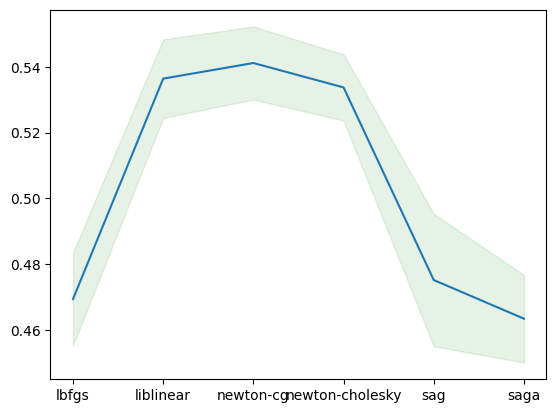

In [62]:
model = LogisticRegression()
hyperparams = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
param_grid = {'solver': hyperparams}
        
print('LogisticRegression results')
model_train(model, param_grid, hyperparams)

In [63]:
grid = GridSearchCV(model, param_grid)

grid.fit(Xtrain, ytrain)
 
 
print(grid.best_params_)

C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\

{'solver': 'newton-cg'}


C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [64]:
model1 = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=4))
])
model2 = Pipeline([
    ('scale', StandardScaler()),
    ('sgd', SGDClassifier(loss='log_loss'))
])
model1.fit(Xtrain, ytrain)
model2.fit(Xtrain, ytrain)
clf1 = model1.predict_proba(Xtest)
clf2 = model2.predict_proba(Xtest)

In [65]:
scores = []
for alpha in np.arange(0.1, 1.1, 0.1):
    res = alpha * clf1 + (1 - alpha) * clf2

    pred = []
    for elem in res:
        pred.append(np.argmax(elem))
    
    print('alpha:', round(alpha, 1))

alpha: 0.1
alpha: 0.2
alpha: 0.3
alpha: 0.4
alpha: 0.5
alpha: 0.6
alpha: 0.7
alpha: 0.8
alpha: 0.9
alpha: 1.0


In [66]:
lr = LogisticRegression(random_state=13)
lr.fit(Xtrain, ytrain)
y_pred_lr = lr.predict(X_test)

print(f"Linear model accuracy: {accuracy_score(y_pred_lr, ytest):.2f}")

Linear model accuracy: 0.46


C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mkuzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [67]:
dt = DecisionTreeClassifier(random_state=13)
dt.fit(Xtrain, ytrain)
y_pred_dt = dt.predict(Xtest)

print(f"Decision tree accuracy: {accuracy_score(y_pred_dt, ytest):.2f}")

Decision tree accuracy: 0.57
